In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
num_epochs = 10
batch_size = 100
learning_rate = 0.001

In [ ]:

#저장할 디렉토리 
root = './MNIST_KMINIST'
#학습할 프로세서 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#transform 설정 , mean 값을 빼준 값에 std 를 나눠줌 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0,), std=(1,))])
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])

#데이터 다운로드
train_data = dset.KMNIST(root=root, train=True, transform=transform, download=True)
test_data = dset.KMNIST(root=root, train=False, transform=transform, download=True)


#데이터를 학습에 맞는 형태로 묶어줌. batch_size 에 맞도록 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)


label_tags = {
    0: 'o', 
    1: 'ki', 
    2: 'su', 
    3: 'tsu', 
    4: 'na', 
    5: 'ha', 
    6: 'ma',
    7: 'ya', 
    8: 're', 
    9: 'wo'
}


In [ ]:
#학습데이터 확인 
print(len(train_loader))
print(len(test_loader))
print(len(train_data))
print(len(test_data))

600
100
60000
10000


In [ ]:
#데이터 관찰 1
mean = 0.0
for i, (imgs, labels) in enumerate(train_loader):
    #mean += img.sum([1,2])/torch.numel(img[0])
    mean += imgs.mean()
mean = mean/i
print(mean)

tensor(-0.6175)


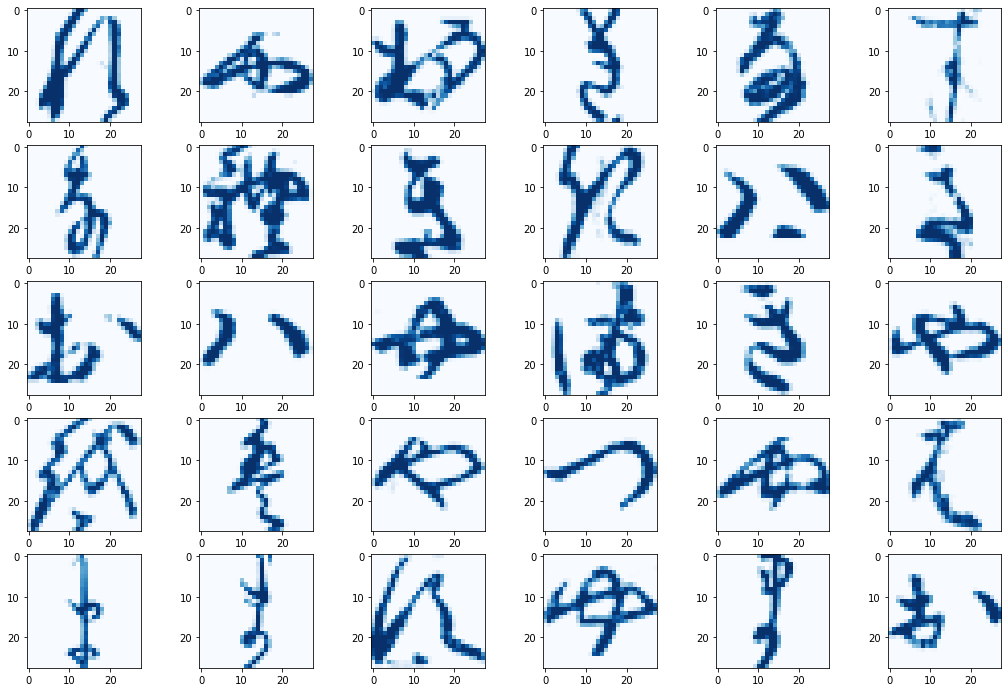

In [ ]:
#데이터 관찰 2
fig = plt.figure(figsize=(18,100))

rows= 40
columns=6
for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
      
        fig.add_subplot(rows, columns, (i+1))
        plot_img = train_data[i][0][0]

        plt.imshow(plot_img,cmap='Blues')
        
        if i >= 29 :
            break
        

In [ ]:

#device = torch.device(device)
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.layer1 = nn.Sequential(
            torch.nn.Linear(784, 256, bias=True),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            torch.nn.Linear(256, 64, bias=True),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            torch.nn.Linear(64, 10, bias=True)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        x_out = self.layer3(x_out)
        return x_out
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight) 
model = DNN().to(device)

#신경망 가중치 초기화 
model.apply(weights_init)

#로스계산 클래스 
criterion = torch.nn.CrossEntropyLoss().to(device)

#옵티마이저 (아담사용)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#학습 
costs = []
total_batch = len(train_loader)

#epoch 반복 
for epoch in range(num_epochs):
    
    total_cost = 0
    
    #mini batch 반복 학습 
    for i, (imgs, labels) in enumerate(train_loader):
        #데이터 batch size 만큼 추출
        imgs, labels = imgs.to(device), labels.to(device)
        #예측실행 
        outputs = model(imgs)
        #예측과 정답 비교 후 loss 계산 
        loss = criterion(outputs, labels)
        
        #옵티마이저
        optimizer.zero_grad()
        
        #학습실행 
        loss.backward()
        optimizer.step()
        
        #로스율 취합 
        total_cost += loss
        
    #로스율 출력 
    avg_cost = total_cost / total_batch
    print("Epoch:", "%03d" % (epoch+1), "Cost =", "{:.9f}".format(avg_cost))  
    costs.append(avg_cost)              

Epoch: 001 Cost = 0.388408452
Epoch: 002 Cost = 0.161461443
Epoch: 003 Cost = 0.106614240
Epoch: 004 Cost = 0.074997894
Epoch: 005 Cost = 0.058902975
Epoch: 006 Cost = 0.045481563
Epoch: 007 Cost = 0.035815477
Epoch: 008 Cost = 0.031188123
Epoch: 009 Cost = 0.029204873
Epoch: 010 Cost = 0.027640533


In [ ]:
#테스트 데이터 전체에 모델돌려서 정답비교 후 결과 출력
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, argmax = torch.max(outputs, 1)
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()
    
    print('Accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))                

Accuracy for 10000 images: 89.98%


In [ ]:
#최종 출력 준비 


#plot에 보여줄 사이즈 
columns = 8
rows = 6


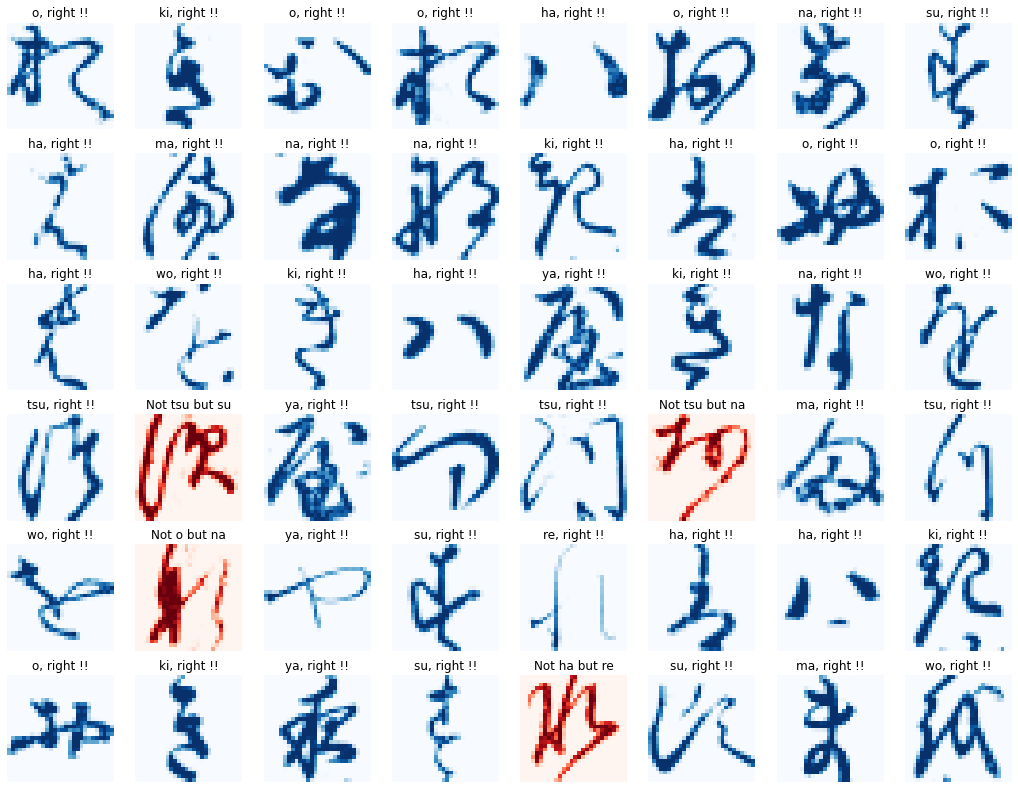

Accuracy for 48 images: 91.67%


In [ ]:
#플롯설정 
fig = plt.figure(figsize=(18,14))
 
model.eval()
cnt = 0 
total_cnt =columns*rows
for i in range(1, columns*rows+1):
    #랜덤으로 테스트데이터에서 이미지 픽업 
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
 
    output = model(input_img)    
    _, argmax = torch.max(output, 1)
    
    
    #print(output)
    #output 에서 몇번째 값이 제일 확률적으로 높은지 표시    
    #print(argmax.item())
    
    pred = label_tags[argmax.item()]
    label = label_tags[test_data[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right !!')
        cmap = 'Blues'
        cnt = cnt +1
        #print("right")
    else:
        plt.title('Not ' + pred + ' but ' +  label)
        cmap = 'Reds'
        #print("error")
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 

print('Accuracy for {} images: {:.2f}%'.format(total_cnt, cnt / total_cnt * 100))  

In [ ]:
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, "model/model_mnist.pt")

torch.save(model.state_dict(), "model/model_mnist_min.pt")

FileNotFoundError: ignored

In [ ]:
PATH = "model/model.pt"

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

FileNotFoundError: ignored